<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [ ]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [ ]:
!pip install -q kaggle
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"polinamoskvicheva","key":"91c107205852aa11160c2144e64d1d74"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dog-breed-identification

 98% 679M/691M [00:08<00:00, 114MB/s]
100% 691M/691M [00:08<00:00, 88.6MB/s]


In [ ]:
!unzip dog-breed-identification.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: data/train/83fad0718581a696132c96c166472627.jpg  
  inflating: data/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: data/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: data/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: data/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: data/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: data/train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  in

Let's use 64 most frequent breeds to simplify the task.

In [ ]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = '/content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [ ]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


<ipython-input-8-0037ea12ab23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['target'] = 1
<ipython-input-8-0037ea12ab23>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['rank'] = labels.groupby('breed').rank()['id']


Custom dataset is going to be useful for our needs.

In [ ]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#img, label = next(iter(train_dl))
print(next(iter(train_dl))[1])


tensor([ 0, 37, 31, 28])


In [ ]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 224, 224]) torch.Size([4])


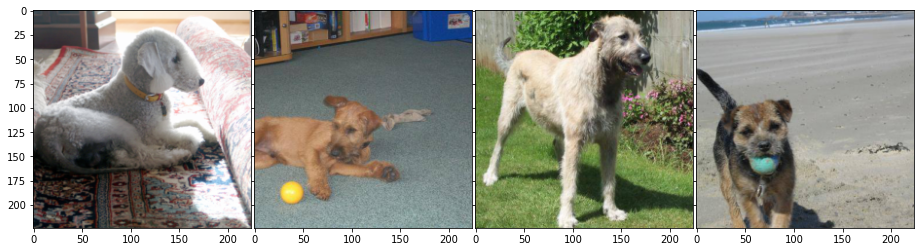

In [ ]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([4, 1000])

This models provides us with 1000 values, representing the classes which ResNet was trained on. 

Replace last layer with one that predicts the 64 classes. 
The network weights should be fixed expected for the last layer that is trained.

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_model(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    # YOUR CODE
    
    loss_res = 0    
    for epoch in range(num_epochs):
        for idx, batch in enumerate(dataloders.get('train')):
            xs, ys_true = batch
            
            logits_pred = model(xs.to(device))
            
            loss = criterion(logits_pred, ys_true.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()                
            outputs = torch.argmax(F.softmax(logits_pred, dim=1), dim=1).detach().cpu()
            accuracy_score = (outputs == ys_true).sum() / outputs.shape[0]

            if idx % 100 == 0:
              print(accuracy_score.item())
              print(loss.item())                
            loss_res += loss.item()

    return loss_res / len(dataloders.get('train'))

In [ ]:
def train_model_one_batch(dataloders,
                model,
                criterion,
                optimizer,
                scheduler,
                num_epochs=1):
    # Train the model and evaluate train and test accuracy
    # YOUR CODE
    
    loss_res = 0    
    batch = next(iter(dataloders.get('train')))
    for epoch in range(num_epochs):
        #batch = next(iter(dataloders.get('train')))
        #for batch in dataloders.get('train'):
        xs, ys_true = batch
            
        logits_pred = model(xs.to(device))
            
        loss = criterion(logits_pred, ys_true.to(device))
            
        optimizer.zero_grad()
        loss.backward()
        print(loss.item())
        optimizer.step()
        #scheduler.step()                
        loss_res += loss.item()

    return loss_res / len(dataloders)

In [ ]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features

resnet.fc = torch.nn.Linear(resnet.fc.in_features, 64)

resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.005, momentum=0.9)
#optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#resnet.fc.train()

Linear(in_features=2048, out_features=64, bias=True)

In [ ]:
#train_error = train_model_one_batch(dloaders, resnet, criterion, optimizer, scheduler, num_epochs=10)


4.009191989898682
3.474832057952881
2.9682555198669434
2.504190683364868
2.0984888076782227
1.7622300386428833
1.4964172840118408
1.2922108173370361
1.1360596418380737
1.0147560834884644


In [ ]:
#print(train_error)

21.02930748462677


In [ ]:
train_error = train_model(dloaders, resnet, criterion, optimizer, scheduler, num_epochs=10)


0.0
4.254871845245361
0.0
3.952146291732788
0.25
2.952388048171997
0.25
3.01483154296875
1.0
0.3266940414905548
1.0
0.21973203122615814
0.75
0.6387498378753662
0.0
3.016120195388794
0.75
0.8606281280517578
0.25
6.094268321990967
0.25
1.8635790348052979
1.0
0.5114961266517639
0.75
0.7229605317115784
0.5
1.7976055145263672
0.5
0.9843160510063171
1.0
0.3053648769855499
0.75
0.4846530258655548
0.75
0.6943676471710205
0.5
1.4862724542617798
0.75
0.9472737312316895
0.5
2.429027795791626
0.75
1.745633840560913
0.5
4.708120346069336
1.0
0.0172737929970026
0.5
2.139313220977783
1.0
0.005449673626571894
0.75
0.7620447874069214
0.75
1.6091125011444092
1.0
0.06943584233522415
0.5
1.6938846111297607
0.75
0.9474747180938721
0.75
1.9765610694885254
0.75
0.5719497203826904
0.75
1.4508121013641357
1.0
0.24975870549678802
0.25
1.6872621774673462
0.5
1.6089072227478027
0.75
2.6407768726348877
0.5
2.3022427558898926
0.75
0.5304779410362244
0.25
2.4154958724975586
0.75
1.0641846656799316
0.75
0.93827718496

In [ ]:
print(train_error)

13.042586037592303


In [ ]:
def test_epoch(net, loader, criterion, device): 
    net.eval()
    loss_res = 0
    for batch in loader.get('valid'):
            xs, ys_true = batch
            
           
            with torch.no_grad():
                logits_pred = net(xs.to(device))
                loss = criterion(logits_pred, ys_true.to(device))
                            
                loss_res += loss.item()

    return loss_res / len(loader.get('valid'))

In [ ]:
val_error = test_epoch(resnet, dloaders, criterion, device)
print(val_error)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0.9521607194687678


In [ ]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device): 
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_model(train_loader, net, criterion, optimizer, scheduler)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f" 
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))
    
    return train_losses, test_losses

In [ ]:
epochs = 10
train(resnet, dloaders, dloaders, optimizer, epochs, criterion, device)

1.0
0.0006514302804134786
0.75
0.43372052907943726
1.0
0.04921877756714821
1.0
0.005225253291428089


KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in dloaders['valid']:
        inputs, labels = data
        outputs = resnet(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy on test: ',
    100 * correct / total)

Accuracy on test:  85.2892561983471


In [ ]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

In [ ]:
# data = dloaders['valid']
# for i, (inputs, labels) in enumerate(data):
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)
#         print(preds)

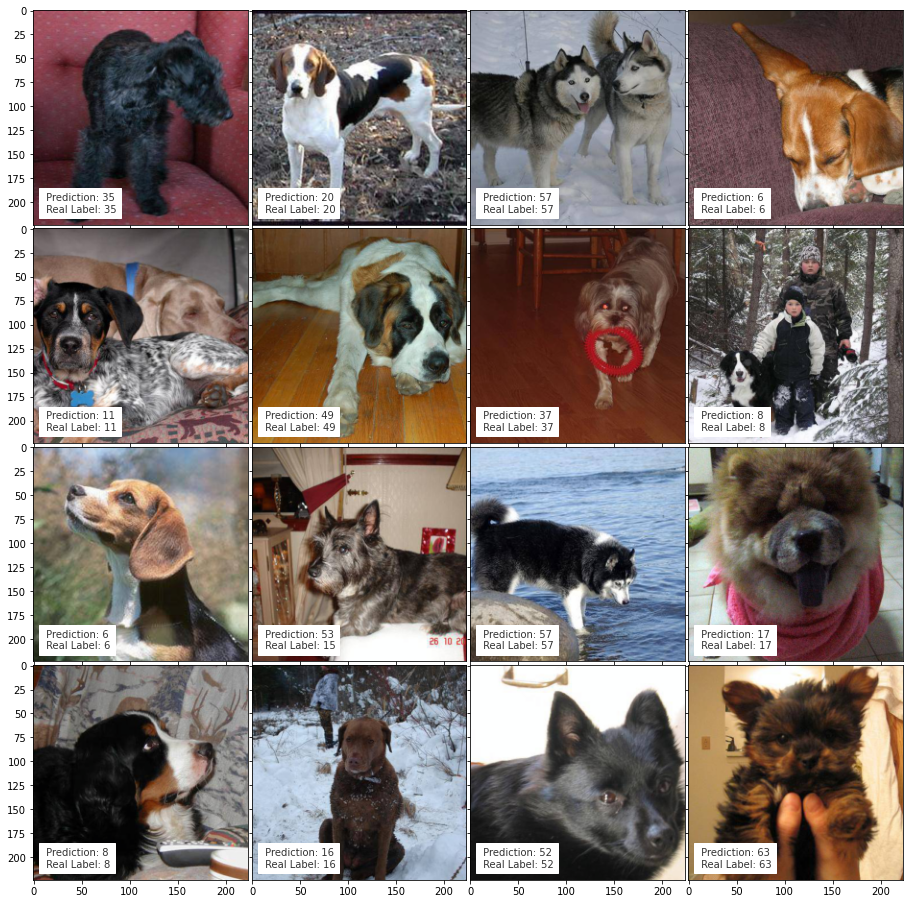

In [ ]:
visualize_model(dloaders, resnet)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session). 

Latent space interpolation part

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step. 
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both. 

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share. 